In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import time
import statistics
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)

In [4]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)

In [5]:
def build_test_stack(n_layers: int):
    parameters_container = ParametersContainer()
    comp_SrTiO3 = create_compound(
        parameters_container=parameters_container,
        name="SrTiO3",
        formula="Sr:1,Ti:1,O:3",
        thickness=50.0,
        density=5.12,
        atoms=[sr_atom, ti_atom, o_atom],
        roughness=0.0,
        prev_roughness=0.0,
        linked_prev_roughness=False,
    )
    comp_LaMnO3 = create_compound(
        parameters_container=parameters_container,
        name="LaMnO3",
        formula="La:1,Mn:1,O:3",
        thickness=10.0,
        density=6.52,
        atoms=[la_atom, mn_atom, o_atom],
        roughness=0,
        prev_roughness=0.0,
        linked_prev_roughness=False,
    )
    
    total_thickness = comp_SrTiO3.thickness.get() + comp_LaMnO3.thickness.get()

    struc = Structure(name=f"Test Structure-{total_thickness}", n_compounds=2, params_container=parameters_container)
    struc.add_compound(0, comp_SrTiO3)
    struc.add_compound(1, comp_LaMnO3)
    struc.validate_compounds()
    struc.create_layers(step=total_thickness / n_layers)
    
    return struc


def measure(name, func, *args, runs=30):
    times = []
    
    for _ in range(runs):
        t0 = time.perf_counter()
        func(*args)
        times.append(time.perf_counter() - t0)
    
    media = statistics.mean(times)
    desv   = statistics.stdev(times)

    return {
        "name": name,
        "media": media,
        "desv": desv,
        "runs": runs,
    }

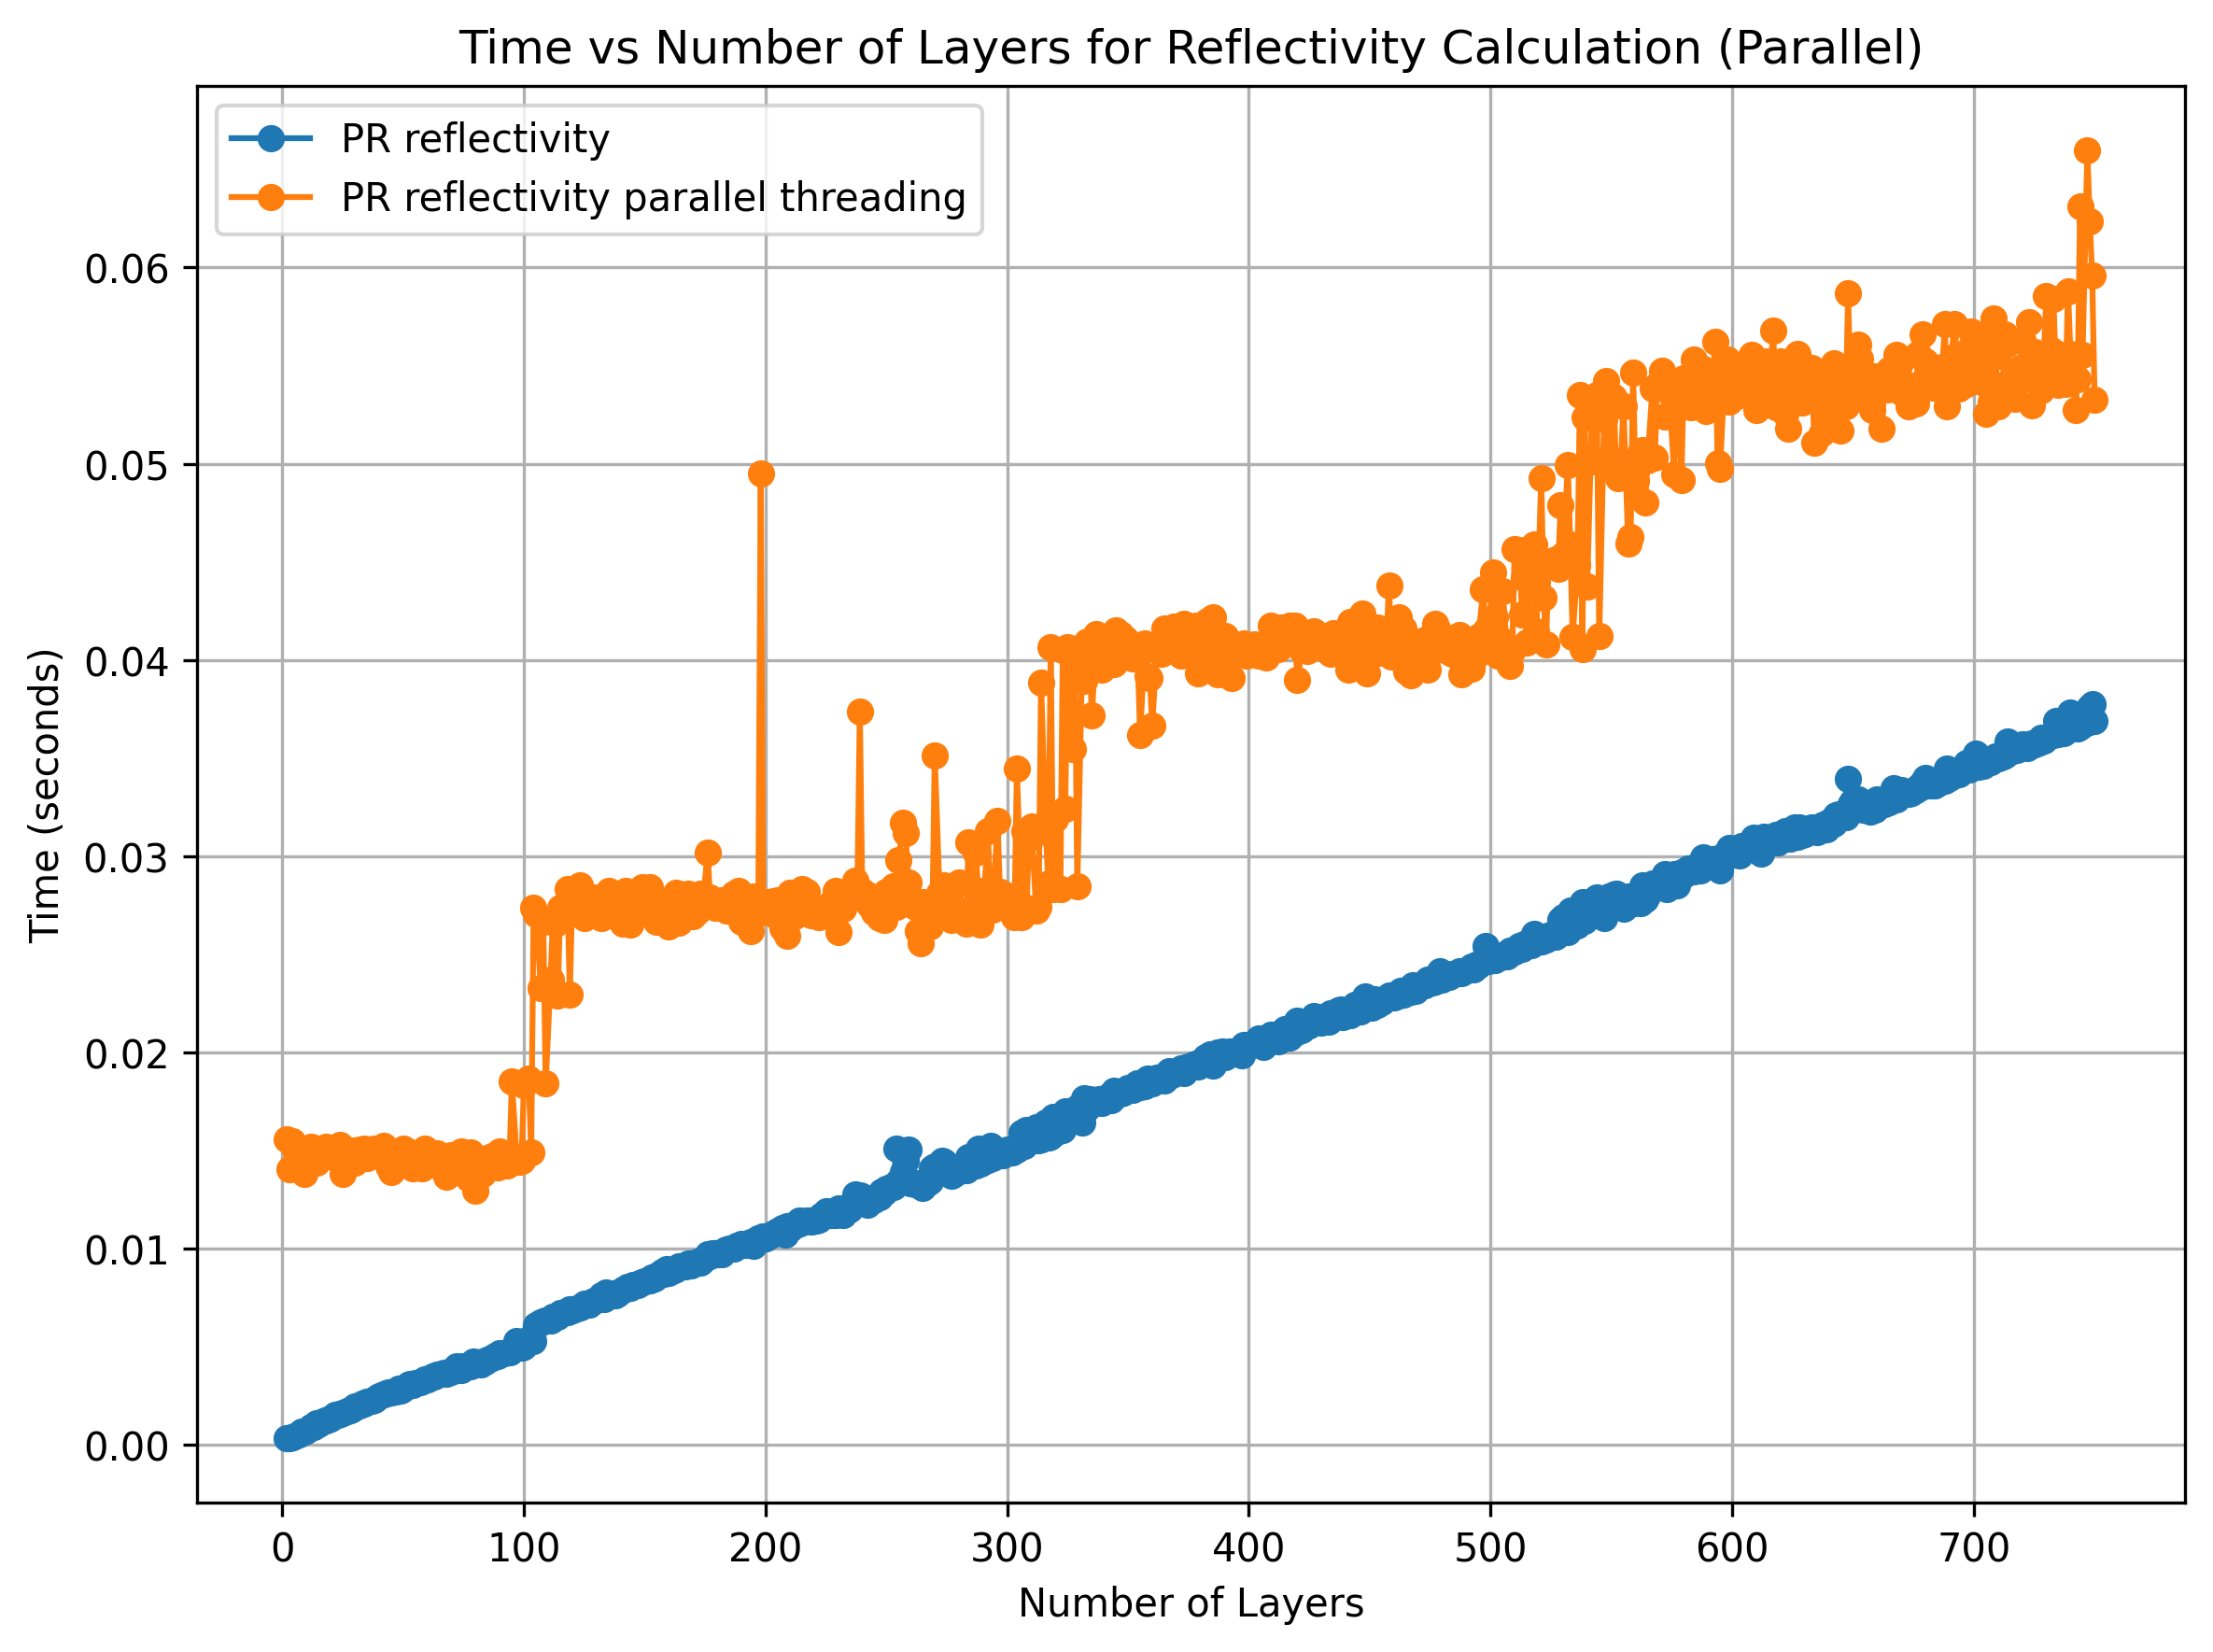

In [13]:
E_eV = 836.0
Theta = np.linspace(0.1, 89.1, num=300)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

backend_ref = PRReflectivityBackend(als=False)
backend_ref_parallel = PRParallelReflectivityBackend(als=False, use_threads=True)

N_layers_max = 600
times_results = {}
n_layers_res = []
for n_layers in range(1, N_layers_max + 1):
    stack = build_test_stack(n_layers)
    n_layers_res.append(stack.n_layers)

    tests = [
        ("PR reflectivity", backend_ref.compute_reflectivity, stack, qz, E_eV),
        ("PR reflectivity parallel threading", backend_ref_parallel.compute_reflectivity, stack, qz, E_eV),
    ]

    for name, fn, *args in tests:
        result = measure(name, fn, *args, runs=3)
        if name not in times_results:
            times_results[name] = []
        times_results[name].append(result['media'])


plt.figure(figsize=(8, 6), dpi=300)
for name, times in times_results.items():
    plt.plot(n_layers_res, times, label=name, marker='o', linestyle='-')
plt.xlabel("Number of Layers")
plt.ylabel("Time (seconds)")
plt.title("Time vs Number of Layers for Reflectivity Calculation (Parallel)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

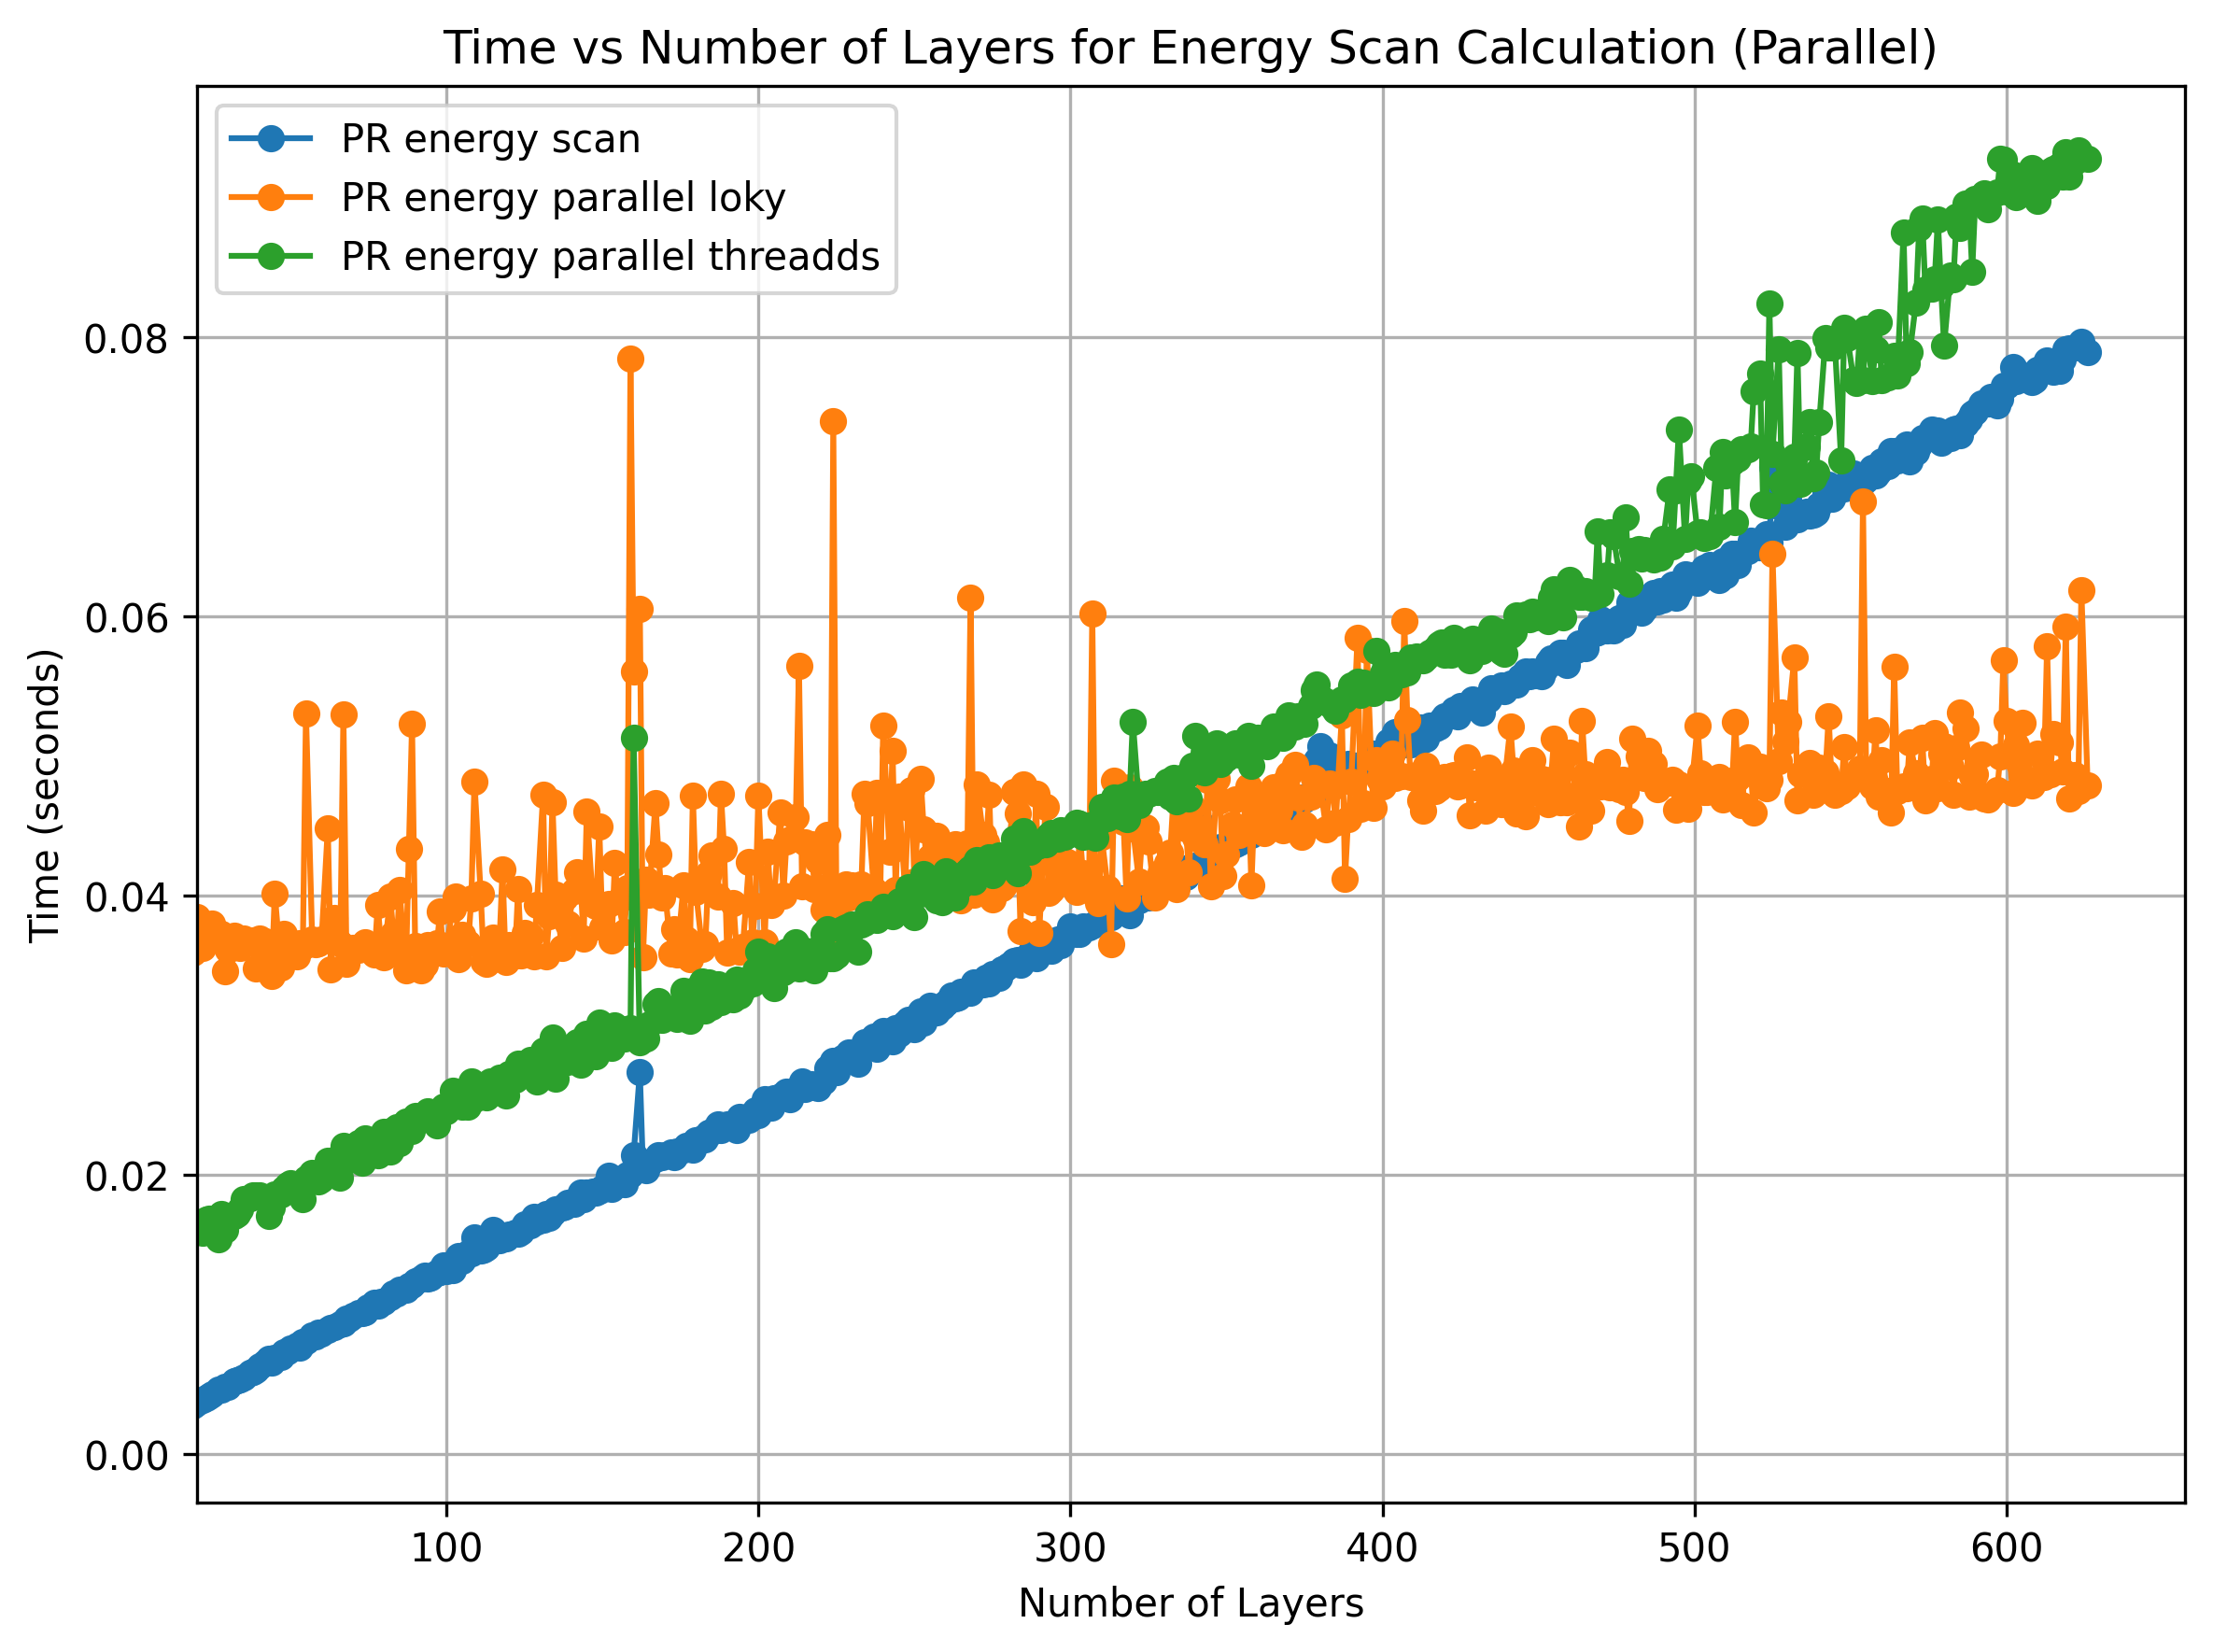

In [16]:
E_eVs = np.linspace(630, 670, 100).tolist()
Theta = 15

backend_ref = PRReflectivityBackend(als=False)
backend_ref_parallel = PRParallelReflectivityBackend(als=False, use_threads=False)
backend_ref_parallel_threads = PRParallelReflectivityBackend(als=False, use_threads=True)

N_layers_max = 500
times_results = {}
n_layers_res = []
for n_layers in range(1, N_layers_max + 1):
    stack = build_test_stack(n_layers)
    n_layers_res.append(stack.n_layers)

    tests = [
        ("PR energy scan", backend_ref.compute_energy_scan, stack, E_eVs, Theta),
        ("PR energy parallel loky", backend_ref_parallel.compute_energy_scan, stack, E_eVs, Theta),
        ("PR energy parallel threadds", backend_ref_parallel_threads.compute_energy_scan, stack, E_eVs, Theta),
    ]

    for name, fn, *args in tests:
        result = measure(name, fn, *args, runs=3)
        if name not in times_results:
            times_results[name] = []
        times_results[name].append(result['media'])


plt.figure(figsize=(8, 6), dpi=300)
for name, times in times_results.items():
    plt.plot(n_layers_res, times, label=name, marker='o', linestyle='-')
plt.xlabel("Number of Layers")
plt.ylabel("Time (seconds)")
plt.title("Time vs Number of Layers for Energy Scan Calculation (Parallel)")
plt.legend()
plt.grid(True)
plt.xlim(left=20)
plt.tight_layout()
plt.show()